<a href="https://colab.research.google.com/github/iamavi27/Human-Body-BG-Removal/blob/main/Human_Body_BG_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from PIL import Image

# Data
import cv2 as cv
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import resize

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers import concatenate

from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d laurentmih/aisegmentcom-matting-human-datasets

Dataset URL: https://www.kaggle.com/datasets/laurentmih/aisegmentcom-matting-human-datasets
License(s): other
100% 28.8G/28.8G [06:52<00:00, 60.5MB/s]
100% 28.8G/28.8G [06:52<00:00, 74.9MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/aisegmentcom-matting-human-datasets.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# import matplotlib.pyplot as plt

# class ShowImagesCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data, num_images=5):
#         self.validation_data = validation_data
#         self.num_images = num_images

#     def on_epoch_end(self, epoch, logs=None):
#         X_valid, y_valid = self.validation_data
#         idx = np.random.choice(len(X_valid), self.num_images, replace=False)
#         X_sample = X_valid[idx]
#         y_sample = y_valid[idx]
#         y_pred = self.model.predict(X_sample)

#         fig, axes = plt.subplots(self.num_images, 3, figsize=(15, 5 * self.num_images))
#         for i in range(self.num_images):
#             axes[i, 0].imshow(X_sample[i])
#             axes[i, 0].set_title("Input Image")
#             axes[i, 1].imshow(y_sample[i].squeeze(), cmap='gray')
#             axes[i, 1].set_title("Ground Truth")
#             axes[i, 2].imshow(y_pred[i].squeeze(), cmap='gray')
#             axes[i, 2].set_title("Prediction")

#         plt.tight_layout()
#         plt.show()


In [ ]:
def ShowImage(image, title=None, cmap=None):
    '''This function takes image, title and cmap as the input and plot the image. With the respective configuration.'''
    plt.imshow(image, cmap=cmap)
    if title is not None : plt.title(title)
    plt.axis('off')

In [ ]:
def data_loader(image_df, matting_df, IMAGE_SIZE=256, BATCH_SIZE=64, channels =[3,1]):
    '''
    In simple words, this function takes in the image data frame and the matching data frame and selects
    random images with the help of Numpy permutation of the batch size.

    Then it loads that image converted to a Numpy array, resize the image and finally create the mask out
    of the matting and return the image, matting and the mask.

    '''

    idxs = np.random.permutation(len(image_df))[:BATCH_SIZE]

    images = np.zeros(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, channels[0]))
    mattings = np.zeros(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, channels[0]))
    masks = np.zeros(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, channels[1]))

    for i, id in enumerate(idxs):
        image_path = root_img + "/" + image_df["Folder_ID"][id] + "/" + image_df["Clip_ID"][id] + '/' + image_df["Image_ID"][id]
        matting_path = root_mask + "/" + matting_df["Folder_ID"][id] + "/" + matting_df["Matting_ID"][id] + '/' + matting_df["Image_ID"][id]

        image = resize(img_to_array(load_img(image_path))/255., (IMAGE_SIZE, IMAGE_SIZE)).numpy()
        matting = resize(img_to_array(load_img(matting_path))/255.,(IMAGE_SIZE, IMAGE_SIZE)).numpy()
        mask = (matting>0).astype('float')

        images[i] = image
        mattings[i] = matting
        masks[i] = mask[:,:,:1]
    return images, mattings, masks

In [ ]:
def map(image,mask,th):
    '''
    This function takes in the image and the mask (produced by the model).
    And produce matting out of this image and mask using the Numpy "where" function.
    '''
    return np.where(mask>th,image,mask)

In [ ]:
def Learning_Curve(data):
    '''
    Takes in the results generated by the model training and plot them
    '''
    pd.DataFrame(data.history).plot(figsize=(8,5))
    plt.grid()
    plt.show()

In [ ]:
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs):
        plt.figure(figsize=(15,8))
        image, _, mask = data_loader(image_df, matting_df, BATCH_SIZE=1, IMAGE_SIZE=224)
        pred_mask = self.model.predict(image)[0]
        mapping = map(image, pred_mask, 0.5)[0]

        plt.subplot(1,4,1)
        ShowImage(image[0],title="True Image")

        plt.subplot(1,4,2)
        ShowImage(pred_mask, title="Predicted Mask", cmap='gray')

        plt.subplot(1,4,3)
        ShowImage(mask[0].reshape(IMAGE_SIZE, IMAGE_SIZE), title="True Mask", cmap='gray')

        plt.subplot(1,4,4)
        ShowImage(mapping, title="Mapped Image")

        plt.tight_layout()
        plt.show()

Data

In [ ]:
image_df = pd.DataFrame(columns=["Folder_ID","Clip_ID","Image_ID"], index=range(34427))
matting_df = pd.DataFrame(columns=["Folder_ID","Matting_ID","Image_ID"], index=range(34427))

As the data is distributed into multiple subdirectories, we will have to go in into all the directories and gather the images sequentially.

In [ ]:
import os

# Define the path to the directories you want to create
root_img = '/content/clip_img'
root_mask = '/content/matting'



In [ ]:
image_folders = sorted(os.listdir(root_img))
matting_folders = sorted(os.listdir(root_mask))

In [ ]:
clip_image_dirs = [sorted(os.listdir(root_img + '/' + folder)) for folder in image_folders]
clip_matting_dirs = [sorted(os.listdir(root_mask + '/' + folder)) for folder in matting_folders]

In [ ]:
%%time
k=0
for i,folder in enumerate(image_folders):
    for clip in clip_image_dirs[i]:
        for image_id in os.listdir(root_img + '/' + folder + '/' + clip):

            image_df["Folder_ID"][k] = folder
            image_df['Clip_ID'][k] = clip
            image_df["Image_ID"][k] = image_id

            matting_df["Folder_ID"][k] = folder
            matting_id = clip.split('_')[-1]
            matting_df["Matting_ID"][k] = "matting_" + matting_id # the clip ID is changed to matting ID.
            image_id = image_id.split(".")[0]
            matting_df["Image_ID"][k] = image_id + ".png" # the mating images are in PNG format.
            k+=1

CPU times: user 1min 3s, sys: 484 ms, total: 1min 4s
Wall time: 1min 4s


In [ ]:
image_df.head()

,Folder_ID,Clip_ID,Image_ID
0,1803151818,clip_00000000,1803151818-00000104.jpg
1,1803151818,clip_00000000,1803151818-00000415.jpg
2,1803151818,clip_00000000,1803151818-00000704.jpg
3,1803151818,clip_00000000,1803151818-00000899.jpg
4,1803151818,clip_00000000,1803151818-00000991.jpg


In [ ]:
matting_df.head()

,Folder_ID,Matting_ID,Image_ID
0,1803151818,matting_00000000,1803151818-00000104.png
1,1803151818,matting_00000000,1803151818-00000415.png
2,1803151818,matting_00000000,1803151818-00000704.png
3,1803151818,matting_00000000,1803151818-00000899.png
4,1803151818,matting_00000000,1803151818-00000991.png


In [ ]:
image_df.isnull().sum()

Folder_ID    0
Clip_ID      0
Image_ID     0
dtype: int64

You can understand these data frames as the path of the images mapped into a data frame. Let's check if the exact same row in the image data frame and the matting data frame represents the same image or not.

In [ ]:
row_id = np.random.randint(len(image_df))  #Random
print(image_df.iloc[row_id])
print("\n")
print(matting_df.iloc[row_id])

Folder_ID                 1803250215
Clip_ID                clip_00000000
Image_ID     1803250215-00000266.jpg
Name: 18637, dtype: object


Folder_ID                  1803250215
Matting_ID           matting_00000000
Image_ID      1803250215-00000266.png
Name: 18637, dtype: object


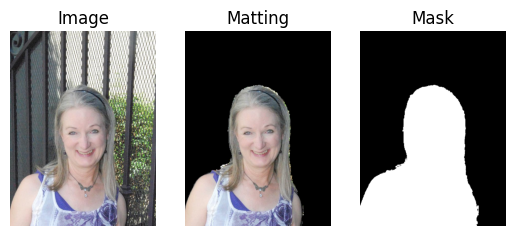

In [ ]:
image_path = root_img + "/" + image_df["Folder_ID"][row_id] + "/" + image_df["Clip_ID"][row_id] + '/' + image_df["Image_ID"][row_id]
image = img_to_array(load_img(image_path))/255.

matting_path = root_mask + "/" + matting_df["Folder_ID"][row_id] + "/" + matting_df["Matting_ID"][row_id] + '/' + matting_df["Image_ID"][row_id]
matting = img_to_array(load_img(matting_path))/255.

mask = (matting[:,:,0]>0).astype('float')

plt.subplot(1,3,1)
ShowImage(image, title="Image")
plt.subplot(1,3,2)
ShowImage(matting, title="Matting")
plt.subplot(1,3,3)
ShowImage(mask, title="Mask", cmap='gray')

In [ ]:
images, mattings, masks = data_loader(image_df, matting_df, IMAGE_SIZE=224, BATCH_SIZE=5)

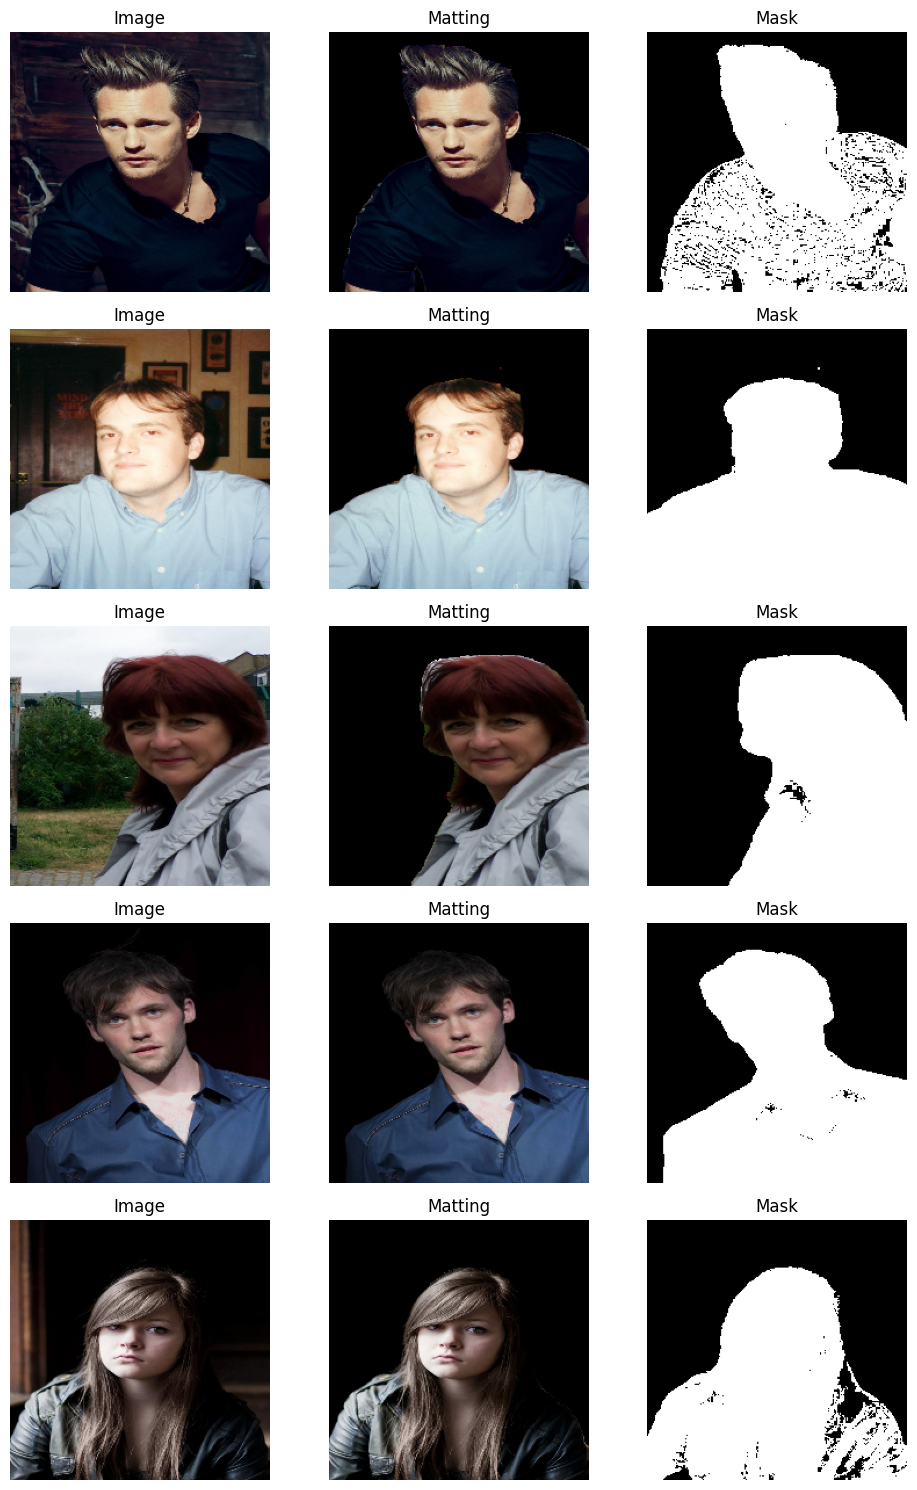

In [ ]:
plt.figure(figsize=(10,15))
n=0
k = 0
for i in range(1,16):
    plt.subplot(5,3,i)

    if n==0:
        image = images[k].astype('float')
        matting = mattings[k]
        mask = masks[k]
        ShowImage(image, title="Image")
        k+=1
        n+=1
    elif n==1:
        ShowImage(matting, title="Matting")
        n+=1
    elif n==2:
        ShowImage(mask, title="Mask", cmap='gray')
        n=0
plt.tight_layout()
plt.show()

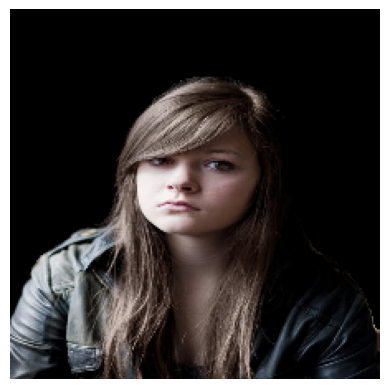

In [ ]:
img = map(image, mask, 0)
ShowImage(img)

In [ ]:
# class EncoderLayerBlock(Layer):
#     def __init__(self, filters, rate, pooling=True):
#         super(EncoderLayerBlock, self).__init__()
#         self.filters = filters
#         self.rate = rate
#         self.pooling = pooling

#         self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='selu', kernel_initializer='he_normal')
#         self.drop = Dropout(self.rate)
#         self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='selu', kernel_initializer='he_normal')
#         self.pool = MaxPool2D(pool_size=(2,2))

#     def call(self, X):
#         x = self.c1(X)
#         x = self.drop(x)
#         x = self.c2(x)
#         if self.pooling:
#             y = self.pool(x)
#             return y, x
#         else:
#             return x

#     def get_config(self):
#         base_estimator = super().get_config()
#         return {
#             **base_estimator,
#             "filters":self.filters,
#             "rate":self.rate,
#             "pooling":self.pooling
#         }

# class DecoderLayerBlock(Layer):
#     def __init__(self, filters, rate):
#         super(DecoderLayerBlock, self).__init__()
#         self.filters = filters
#         self.rate = rate
#         self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding='same')
#         self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

#     def call(self, X):
#         X, skip_X = X
#         x = self.cT(X)
#         c1 = concatenate([x, skip_X])
#         y = self.next(c1)
#         return y

#     def get_config(self):
#         base_estimator = super().get_config()
#         return {
#             **base_estimator,
#             "filters":self.filters,
#             "rate":self.rate,
#         }

In [ ]:
%%time
# X_train, _, y_train = data_loader(image_df,matting_df,224,1000)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


In [ ]:
%%time
# X_valid, _, y_valid = data_loader(image_df,matting_df,224,500)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [ ]:
# with tf.device('/GPU:0'):
#     IMAGE_SIZE = 224

#     # Input Layer
#     input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#     # Encoder
#     p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
#     p2, c2 = EncoderLayerBlock(32,0.1)(p1)
#     p3, c3 = EncoderLayerBlock(32,0.1)(p2)
#     p4, c4 = EncoderLayerBlock(64,0.1)(p3)

#     # Encoding Layer
#     c5 = EncoderLayerBlock(128,0.2,pooling=False)(p4)

#     # Decoder
#     d1 = DecoderLayerBlock(64,0.1)([c5, c4])
#     d2 = DecoderLayerBlock(32,0.1)([d1, c3])
#     d3 = DecoderLayerBlock(32,0.1)([d2, c2])
#     d4 = DecoderLayerBlock(16,0.1)([d3, c1])

#     # Output layer
#     output = Conv2D(1,kernel_size=1,strides=1,padding='same',activation='sigmoid')(d4)

#     # U-Net Model
#     model = keras.models.Model(
#         inputs=[input_layer],
#         outputs=[output],
#     )

#     # Compile
#     model.compile(
#         loss='binary_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy',keras.metrics.MeanIoU(num_classes=2,name='IoU')]
#     )

#     # Callbacks
#     callbacks = [
#         EarlyStopping(patience=5,monitor='val_loss', mode='min',restore_best_weights=True),
#         ModelCheckpoint("UNet-BG-Remover.h5", save_best_only=True),
#         ShowProgress()
#     ]

#     model.fit(
#         X_train, y_train,
#         epochs=100,
#         callbacks=callbacks,
#         validation_data=(X_valid, y_valid)
#     )


Testing model

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, Conv2DTranspose, concatenate, Layer, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
import albumentations as A

# Define data_loader function if it's custom (Placeholder)
# def data_loader(...):
#     ...

class EncoderLayerBlock(Layer):
    def __init__(self, filters, rate, pooling=True):
        super(EncoderLayerBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='selu', kernel_initializer='he_normal')
        self.bn1 = BatchNormalization()
        self.drop = Dropout(self.rate)
        self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='selu', kernel_initializer='he_normal')
        self.bn2 = BatchNormalization()
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, X):
        x = self.c1(X)
        x = self.bn1(x)
        x = self.drop(x)
        x = self.c2(x)
        x = self.bn2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

class DecoderLayerBlock(Layer):
    def __init__(self, filters, rate):
        super(DecoderLayerBlock, self).__init__()
        self.filters = filters
        self.rate = rate
        self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding='same')
        self.bn = BatchNormalization()
        self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.cT(X)
        x = self.bn(x)
        c1 = concatenate([x, skip_X])
        y = self.next(c1)
        return y

    def get_config(self):
        base_estimator = super().get_config()
        return {
            **base_estimator,
            "filters":self.filters,
            "rate":self.rate,
        }

# # Data Augmentation
# def augment_data(images, masks):
#     aug = A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.Rotate(limit=30, p=0.5),
#         A.RandomBrightnessContrast(p=0.2),
#         A.RandomGamma(p=0.2),
#         A.ElasticTransform(p=0.2)
#     ])
#     aug_images = []
#     aug_masks = []
#     for img, mask in zip(images, masks):
#         augmented = aug(image=img, mask=mask)
#         aug_images.append(augmented['image'])
#         aug_masks.append(augmented['mask'])
#     return np.array(aug_images), np.array(aug_masks)

# X_train, _, y_train = data_loader(image_df, matting_df, 224, 1000)
# X_valid, _, y_valid = data_loader(image_df, matting_df, 224, 500)

# # Augment data
# X_train, y_train = augment_data(X_train, y_train)

# with tf.device('/GPU:0'):
#     IMAGE_SIZE = 224

#     # Input Layer
#     input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#     # Encoder
#     p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
#     p2, c2 = EncoderLayerBlock(32,0.1)(p1)
#     p3, c3 = EncoderLayerBlock(32,0.1)(p2)
#     p4, c4 = EncoderLayerBlock(64,0.1)(p3)

#     # Encoding Layer
#     c5 = EncoderLayerBlock(128,0.2,pooling=False)(p4)

#     # Decoder
#     d1 = DecoderLayerBlock(64,0.1)([c5, c4])
#     d2 = DecoderLayerBlock(32,0.1)([d1, c3])
#     d3 = DecoderLayerBlock(32,0.1)([d2, c2])
#     d4 = DecoderLayerBlock(16,0.1)([d3, c1])

#     # Output layer
#     output = Conv2D(1,kernel_size=1,strides=1,padding='same',activation='sigmoid')(d4)

#     # U-Net Model
#     model = tf.keras.models.Model(
#         inputs=[input_layer],
#         outputs=[output],
#     )

#     # Compile
#     model.compile(
#         loss='binary_crossentropy',
#         optimizer=Adam(learning_rate=1e-3),
#         metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=2,name='IoU')]
#     )

#     # Callbacks
#     callbacks = [
#         EarlyStopping(patience=5,monitor='val_loss', mode='min',restore_best_weights=True),
#         ModelCheckpoint("UNet-BG-Remover.h5", save_best_only=True),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 20)),
#         # ShowProgress() # Uncomment if ShowProgress() is defined
#     ]

#     model.fit(
#         X_train, y_train,
#         epochs=100,
#         callbacks=callbacks,
#         validation_data=(X_valid, y_valid)
#     )


In [ ]:
# Data Augmentation
def augment_data(images, masks):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomGamma(p=0.2),
        A.ElasticTransform(p=0.2)
    ])
    aug_images = []
    aug_masks = []
    for img, mask in zip(images, masks):
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        mask = (mask * 255).astype(np.uint8)  # Convert to uint8
        augmented = aug(image=img, mask=mask)
        aug_images.append(augmented['image'] / 255.0)  # Convert back to float32
        aug_masks.append(augmented['mask'] / 255.0)  # Convert back to float32
    return np.array(aug_images), np.array(aug_masks)

In [ ]:
X_train, _, y_train = data_loader(image_df, matting_df, 224, 1000)
X_valid, _, y_valid = data_loader(image_df, matting_df, 224, 500)


In [ ]:
# Augment data
X_train, y_train = augment_data(X_train, y_train)

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.6886 - IoU: 0.2182 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 734ms/step


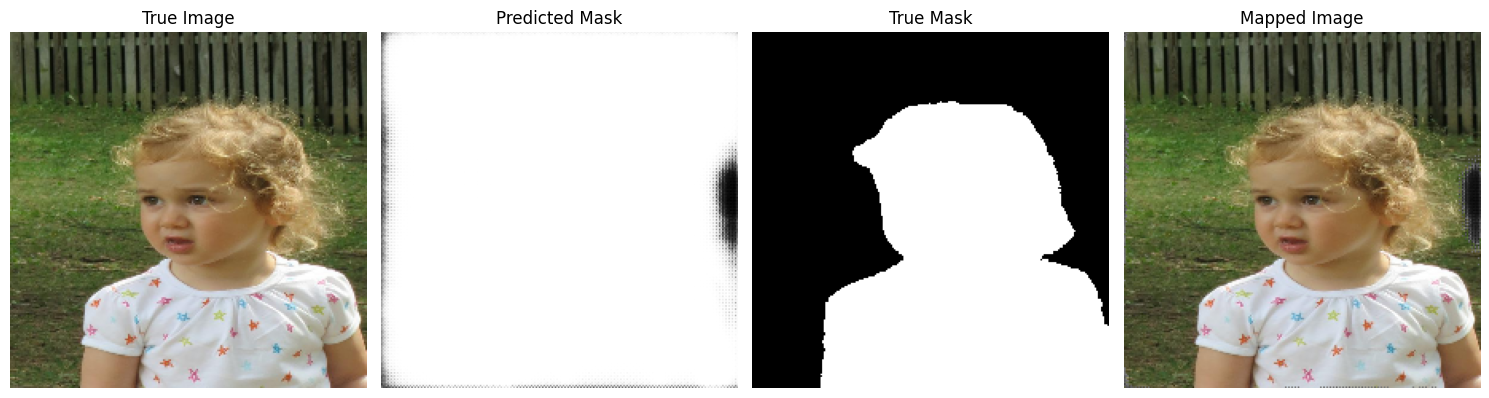

32/32 [==============================] - 670s 21s/step - loss: 0.5947 - accuracy: 0.6886 - IoU: 0.2182 - val_loss: 3.0295 - val_accuracy: 0.6150 - val_IoU: 0.2217
Epoch 2/100
1/1 [==============================] - 0s 222ms/step


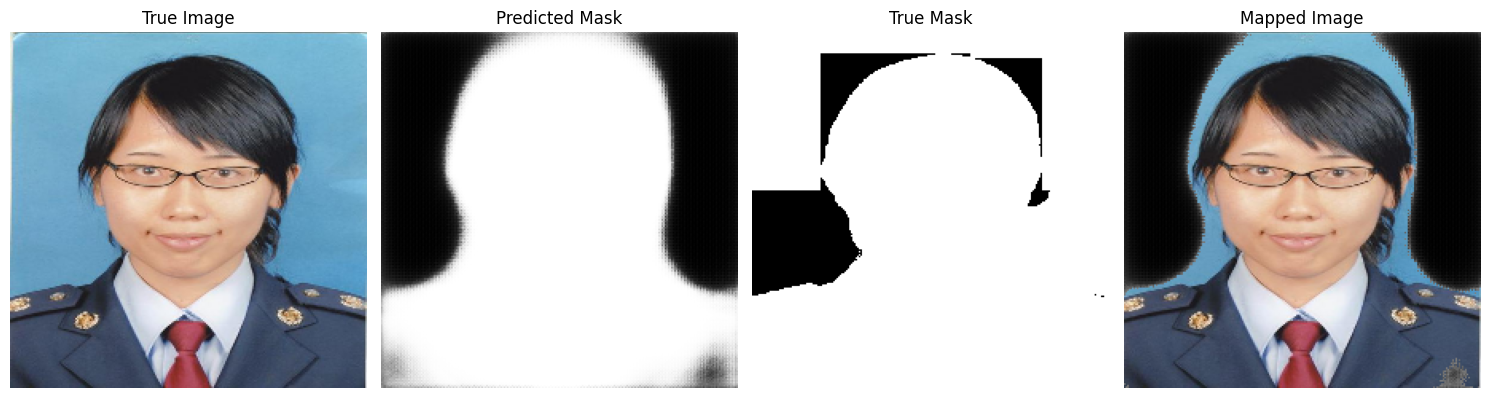

32/32 [==============================] - 667s 21s/step - loss: 0.5117 - accuracy: 0.7482 - IoU: 0.2182 - val_loss: 2.1524 - val_accuracy: 0.6918 - val_IoU: 0.2640
Epoch 3/100
1/1 [==============================] - 0s 219ms/step


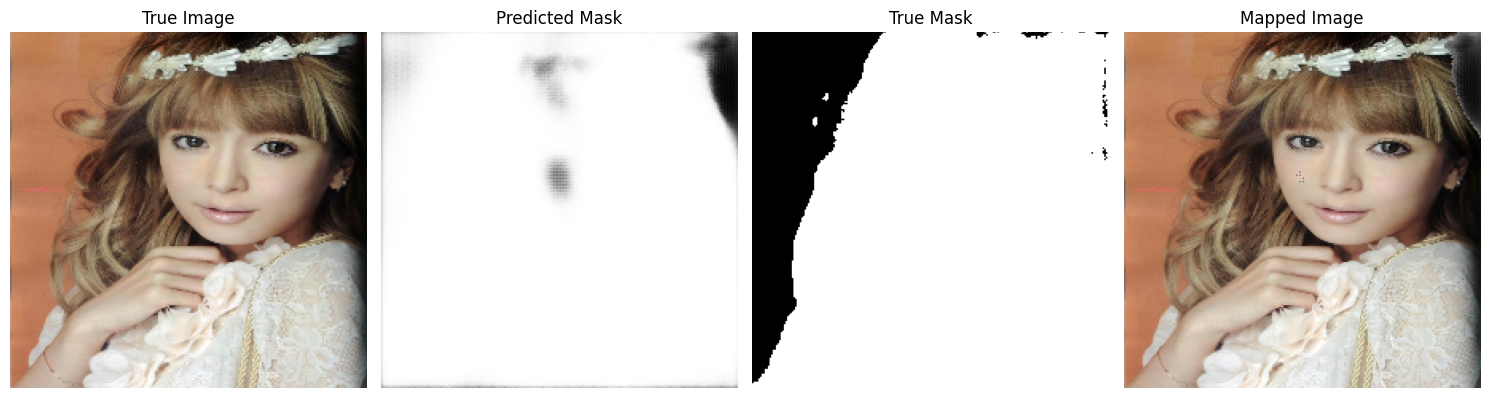

32/32 [==============================] - 653s 20s/step - loss: 0.4876 - accuracy: 0.7632 - IoU: 0.2182 - val_loss: 1.7498 - val_accuracy: 0.6876 - val_IoU: 0.2275
Epoch 4/100
28/32 [=========================>....] - ETA: 1:13 - loss: 0.4631 - accuracy: 0.7764 - IoU: 0.2184

In [ ]:
with tf.device('/GPU:0'):
    IMAGE_SIZE = 224

    # Input Layer
    input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Encoder
    p1, c1 = EncoderLayerBlock(16, 0.1)(input_layer)
    p2, c2 = EncoderLayerBlock(32, 0.1)(p1)
    p3, c3 = EncoderLayerBlock(32, 0.1)(p2)
    p4, c4 = EncoderLayerBlock(64, 0.1)(p3)

    # Encoding Layer
    c5 = EncoderLayerBlock(128, 0.2, pooling=False)(p4)

    # Decoder
    d1 = DecoderLayerBlock(64, 0.1)([c5, c4])
    d2 = DecoderLayerBlock(32, 0.1)([d1, c3])
    d3 = DecoderLayerBlock(32, 0.1)([d2, c2])
    d4 = DecoderLayerBlock(16, 0.1)([d3, c1])

    # Output layer
    output = Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(d4)

    # U-Net Model
    model = tf.keras.models.Model(
        inputs=[input_layer],
        outputs=[output],
    )

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2, name='IoU')]
    )

    # Callbacks
    callbacks = [
        EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True),
        ModelCheckpoint("UNet-BG-Remover.h5", save_best_only=True),
        # tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 20)),
        ShowProgress()  # Custom callback to show images
    ]

    model.fit(
        X_train, y_train,
        epochs=100,
        callbacks=callbacks,
        validation_data=(X_valid, y_valid)
    )

In [ ]:
images, mattings, _ = data_loader(image_df, matting_df, BATCH_SIZE=10, IMAGE_SIZE=224)
n=0
k=0
plt.figure(figsize=(10,25))
for i in range(1,31):
    plt.subplot(10,3,i)

    if n==0:
        image = images[k]
        matting = mattings[k]
        pred_mat = map(image, model.predict(image[np.newaxis,...]),0.1)
        ShowImage(image, title="Original Image")
        n+=1
        k+=1

    elif n==1:
        ShowImage(matting,title="Original Matting")
        n+=1
    elif n==2:
        ShowImage(pred_mat[0], title="Predicted Matting")
        #  n=0
plt.tight_layout()
plt.show()